Notebook to identify the changes of direction per player

In [1]:

from pathlib import Path
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, degrees, atan ,atan2, acos
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from mplsoccer.dimensions import valid
    

mijn idee: gwn naar acceleratie kijken  --> van negatief naar poisitief + bepaalde hoekverandering binnen tijd  (& startsnelheid boven bepaalde treshold)

In [2]:
# secondspectrum pitch dimensions
#"pitchLength": 103.4589780029297
#"pitchWidth": 66.97553049316407

In [3]:
# define the path to the parquet files containing floodlight data: velocity
xy_path = Path("floodlight_parquets/xy_HT1")

In [4]:
# read the velocity data
xy_df = pl.read_parquet(xy_path)

In [5]:
xy_df

C. Coosemans_x,C. Coosemans_y,Amuzu_x,Amuzu_y,M. Rits_x,M. Rits_y,T. Leoni_x,T. Leoni_y,K. Dolberg_x,K. Dolberg_y,K. Sardella_x,K. Sardella_y,A. Dreyer_x,A. Dreyer_y,L. Dendoncker_x,L. Dendoncker_y,J. Simić_x,J. Simić_y,Amando Lapage_x,Amando Lapage_y,Ali Maamar_x,Ali Maamar_y,L. Vázquez_x,L. Vázquez_y,Y. Verschaeren_x,Y. Verschaeren_y,N. Engwanda_x,N. Engwanda_y,Mads Kikkenborg_x,Mads Kikkenborg_y,S. Edozie_x,S. Edozie_y,Thorgan Hazard_x,Thorgan Hazard_y,T. Degreef_x,T. Degreef_y,Thomas Foket_x,Thomas Foket_y,Timon Vanhoutte_x,Timon Vanhoutte_y,Anas Tajaouart_x,Anas Tajaouart_y
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-46.38,-0.06,-0.57,9.02,-12.86,-10.79,-11.02,5.16,-8.04,-3.84,-19.56,-25.26,-8.72,-22.04,-21.03,-7.13,-23.0,-14.83,-21.15,1.56,-19.85,7.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-46.36,-0.06,-0.56,8.96,-12.85,-10.81,-11.06,5.15,-7.99,-3.91,-19.56,-25.25,-8.69,-22.04,-21.04,-7.14,-23.02,-14.83,-21.16,1.56,-19.84,7.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-46.35,-0.08,-0.55,8.9,-12.84,-10.82,-11.1,5.15,-7.94,-3.98,-19.56,-25.24,-8.67,-22.04,-21.05,-7.15,-23.03,-14.84,-21.18,1.55,-19.83,7.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-46.34,-0.1,-0.53,8.83,-12.85,-10.84,-11.14,5.15,-7.89,-4.06,-19.57,-25.23,-8.64,-22.04,-21.06,-7.17,-23.05,-14.84,-21.19,1.54,-19.82,7.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-46.32,-0.1,-0.5,8.75,-12.85,-10.85,-11.18,5.16,-7.84,-4.13,-19.57,-25.22,-8.63,-22.04,-21.07,-7.19,-23.06,-14.84,-21.21,1.53,-19.81,7.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
-19.59,-8.61,19.71,21.62,15.03,20.27,0.48,9.98,18.87,19.47,-2.01,-9.16,15.57,13.18,0.45,9.08,-2.49,-8.64,-0.86,12.13,-0.25,20.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-19.62,-8.59,19.71,21.62,15.0,20.21,0.48,9.96,18.87,19.45,-2.02,-9.17,15.57,13.17,0.44,9.07,-2.49,-8.64,-0.85,12.09,-0.24,20.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-19.66,-8.57,19.71,21.62,14.96,20.14,0.49,9.95,18.87,19.42,-2.03,-9.18,15.57,13.16,0.44,9.05,-2.49,-8.64,-0.84,12.04,-0.23,20.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
x = xy_df.get_column("Amuzu_x").to_list()
y = xy_df.get_column("Amuzu_y").to_list()

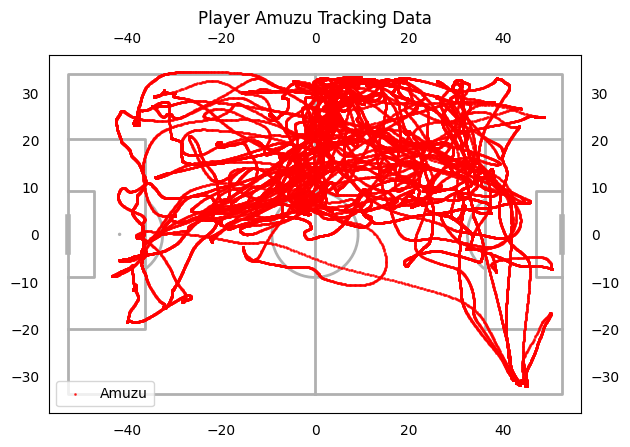

In [7]:
pitch = Pitch(pitch_type='secondspectrum', pitch_length=105, pitch_width=68,
              axis=True, label=True)#, pitch_color='grass', line_color='white', stripe_color='#c2d59d', stripe=True)
fig, ax = pitch.draw()

ax.scatter(x, y, c='red', s=1, label='Amuzu', alpha=0.7)

# Optional: add legend and title
ax.legend()
plt.title('Player Amuzu Tracking Data')

plt.show()

In [8]:
print(x)
print(y)

[-0.57, -0.56, -0.55, -0.53, -0.5, -0.47, -0.42, -0.38, -0.31, -0.25, -0.17, -0.09, -0.01, 0.08, 0.17, 0.27, 0.37, 0.47, 0.59, 0.71, 0.83, 0.97, 1.11, 1.25, 1.4, 1.55, 1.7, 1.86, 2.02, 2.18, 2.36, 2.53, 2.7, 2.88, 3.06, 3.25, 3.43, 3.62, 3.81, 4.0, 4.2, 4.4, 4.59, 4.79, 5.0, 5.2, 5.41, 5.62, 5.84, 6.06, 6.28, 6.5, 6.73, 6.96, 7.19, 7.42, 7.66, 7.9, 8.13, 8.37, 8.61, 8.84, 9.08, 9.32, 9.55, 9.78, 10.01, 10.24, 10.46, 10.68, 10.9, 11.11, 11.32, 11.52, 11.72, 11.91, 12.1, 12.28, 12.46, 12.63, 12.79, 12.95, 13.1, 13.25, 13.39, 13.53, 13.66, 13.79, 13.91, 14.03, 14.14, 14.24, 14.34, 14.44, 14.53, 14.61, 14.69, 14.75, 14.82, 14.88, 14.93, 14.98, 15.02, 15.05, 15.08, 15.09, 15.11, 15.11, 15.11, 15.1, 15.09, 15.07, 15.04, 15.0, 14.97, 14.92, 14.86, 14.8, 14.74, 14.67, 14.59, 14.51, 14.42, 14.32, 14.22, 14.12, 14.01, 13.89, 13.77, 13.65, 13.52, 13.39, 13.26, 13.12, 12.98, 12.83, 12.68, 12.53, 12.38, 12.22, 12.06, 11.9, 11.74, 11.58, 11.41, 11.24, 11.07, 10.9, 10.72, 10.55, 10.37, 10.2, 10.02, 9

In [9]:
print(min(x))
print(max(x))
print(min(y))
print(max(y))

-43.17
50.33
-32.25
34.55


Kai et al 2021: A new approach to quantify angles and time of changes-of-direction during soccer matches

-done-

In [10]:
# testing variables to use as input for a small scale test
x_test = [-12,-9,-6,-3,0,3,5,6,7,8,9,10,10,10,10,10,10,10,10,10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 12, 14, 16, 19, 22, 22, 22]
y_test = [0,0,0,0,0,0,0,0,0,0,0,1,2,4,6,9,12,13,14, 15, 15.5, 16, 16.5, 17, 17.5, 18, 18.5, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19]
print(x_test)
print(y_test)
#x_test.reverse()

[-12, -9, -6, -3, 0, 3, 5, 6, 7, 8, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 12, 14, 16, 19, 22, 22, 22]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 4, 6, 9, 12, 13, 14, 15, 15.5, 16, 16.5, 17, 17.5, 18, 18.5, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19]


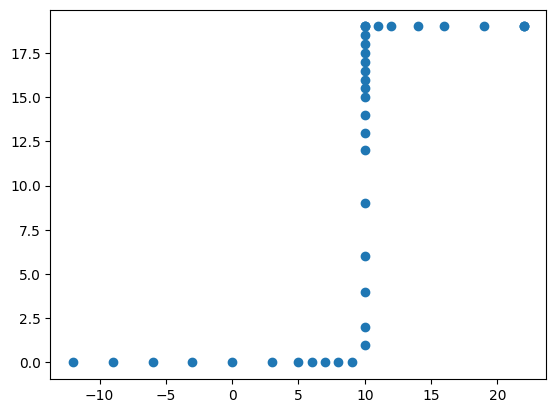

In [11]:
plt.scatter(x_test, y_test)

In [12]:
# define delta t = length of a frame
delta_t = 0.04

In [13]:
d_list = [] # store direction of speed per frame

for i in range(len(x)): 
    if i>0 and i<len(x)-1:
        x1=x[i-1]
        y1=y[i-1]
        
        x2=x[i+1]
        y2=y[i+1]
        
        # atan return the arc tangent of x/y in radians
        # degrees converts the arctan to degrees
        d=degrees(atan2(y2 - y1, x2 - x1)) # alternative: arctan
        d_list.append(d)
        
    else: 
        d=0
        d_list.append(d)
        
d_list[-1]=d_list[-2] # equal angle in last frame to 2nd last frame to avoid incorrect 0 angle

#print(min(d_list))    
#print(max(d_list))
d_list

[0,
 -80.53767779197436,
 -77.00538320808356,
 -71.56505117707802,
 -70.55996517182378,
 -64.79887635452492,
 -62.10272896905237,
 -58.57043438516145,
 -55.619655276155065,
 -55.007979801441486,
 -52.69605172201668,
 -52.69605172201645,
 -51.00900595749452,
 -51.95295746817396,
 -52.76516601842533,
 -52.43140797117248,
 -51.34019174590991,
 -48.65222278030634,
 -47.290610042638505,
 -47.290610042638505,
 -44.99999999999997,
 -42.878903603338514,
 -42.87890360333862,
 -42.95459151111284,
 -41.987212495816614,
 -41.987212495816614,
 -41.05481377096248,
 -40.15599962491937,
 -41.18592516570958,
 -39.47245984834387,
 -37.64762064010772,
 -38.453709216705896,
 -38.659808254090024,
 -37.87498365109824,
 -37.11686068327029,
 -38.08877288097531,
 -39.03551289874686,
 -38.290163192243064,
 -38.29016319224314,
 -37.56859202882747,
 -35.94211187138232,
 -36.63411387596744,
 -36.634113875967394,
 -34.33021719550334,
 -33.36636600105955,
 -32.3806777065692,
 -30.762719534238922,
 -28.14160123226173

In [14]:
v_list = [] # store speed per frame

for i in range(len(x)): 
    if i!=0 and i<len(x)-1:
        x_vector=(x[i+1]-x[i-1])**2
        y_vector=(y[i+1]-y[i-1])**2
        
        v=sqrt((x_vector+y_vector))/(delta_t*2)
        
    else: 
        v=0
    v_list.append(v)
    
    #print(v)
    
v_list[0]=v_list[1] # equal speed in frame 2 to frame 1 to avoid incorrect 0 speed
v_list[-1]=v_list[-2] # equal speed in last frame to 2nd last frame to avoid incorrect 0 speed

#print(min(v_list))    
#print(max(v_list))

In [15]:
#v_list

In [16]:
#range(len(v_list))

In [17]:

# not the standard formula --> takes the centered difference
a_list = [] # store acceleration per frame
for i in range(len(v_list)):
    if i>=1 and i<len(v_list)-1: # only start calculations from 2nd element & avoid the last element to avoid false values
        v1=abs(v_list[i-1]) # v_list[i-1]
        v2=abs(v_list[i+1]) # v_list[i+1]
        
        #a=(sqrt((v2-v1)**2)/(delta_t*2)) # original formula of the paper --> seems wrong, a deceleration of 10m/s to 5m/s would be seen as an accelaration
        a=(v2-v1)/(delta_t*2) #test without the **2 & sqrt --> allowing negative values
        
    else: 
        a=0
    
    a_list.append(a)
    
    #print(a)
    
#print(min(a_list))    
#print(max(a_list))

a_list[0]=a_list[1] # equal speed in frame 2 to frame 1 to avoid incorrect 0 speed
a_list[-1]=a_list[-2] # equal speed in last frame to 2nd last frame to avoid incorrect 0 speed

In [18]:
#a_list

In [19]:
# calculate jerk
j_list = [] # store jerk per frame
for i in range(len(a_list)):
    if i>=1 and i<len(a_list)-1:
        a1=a_list[i-1] # paper takes absolute value
        a2=a_list[i+1] # paper takes absolute value
        
        #j=sqrt(((a2-a1)**2)/(2*delta_t))
        j=((a2-a1))/(2*delta_t)
        
    else: 
        j=0
    
    j_list.append(j)

j_list[0]=j_list[1] # equal jerk in frame 2 to frame 1 to avoid incorrect 0 jerk
j_list[-1]=j_list[-2] # equal jerk in last frame to 2nd last frame to avoid incorrect 0 jerk

#print(min(j_list))    
#print(max(j_list))
j_list

[48.236801498350054,
 48.236801498350054,
 68.55377557936487,
 -13.065572520148017,
 -67.938762282073,
 -13.089395420721877,
 50.36556875820129,
 19.753110157529136,
 -7.955392701673802,
 -25.985191178084303,
 -53.931134592211926,
 15.971871771714646,
 73.52285462262158,
 15.446660792197775,
 -73.57696314557627,
 -60.4895024162682,
 53.76965991786984,
 30.913041762399008,
 -38.711918807652346,
 14.538552889893086,
 1.0635377264255064,
 -27.598733592676254,
 13.877579389653672,
 -13.195947936116003,
 -27.386491233742092,
 15.045391812351372,
 12.934301323861835,
 13.058936923402985,
 5.322564275635627,
 -54.793606622646074,
 -20.814287270174287,
 55.063959193093346,
 18.76492029339108,
 -15.367387140109157,
 -6.7377138217453165,
 0.012042251192195819,
 -8.842541609274113,
 -12.020546885523341,
 4.116235705449999,
 -27.18811587125183,
 -35.110729448296766,
 32.25784585962788,
 25.33994337683615,
 -41.95657816028236,
 -13.783056812059908,
 25.69568278643006,
 1.7859868892655673,
 -20.5763

In [35]:

pl.Config.set_tbl_rows(5)
df = pl.DataFrame({
    "x": pl.Series("x", x, dtype=pl.Float64),
    "y": pl.Series("y", y, dtype=pl.Float64),
    "v": pl.Series("v", v_list, dtype=pl.Float64),
    "a": pl.Series("a", a_list, dtype=pl.Float64),
    "j": pl.Series("j", j_list, dtype=pl.Float64),
    "d": pl.Series("d", d_list, dtype=pl.Float64)
})
df


x,y,v,a,j,d
f64,f64,f64,f64,f64,f64
-0.57,9.02,1.520691,1.837717,48.236801,0.0
-0.56,8.96,1.520691,1.837717,48.236801,-80.537678
-0.55,8.9,1.667708,5.696661,68.553776,-77.005383
…,…,…,…,…,…
19.71,21.62,0.0,0.0,0.0,0.0
19.71,21.62,0.0,0.0,0.0,0.0


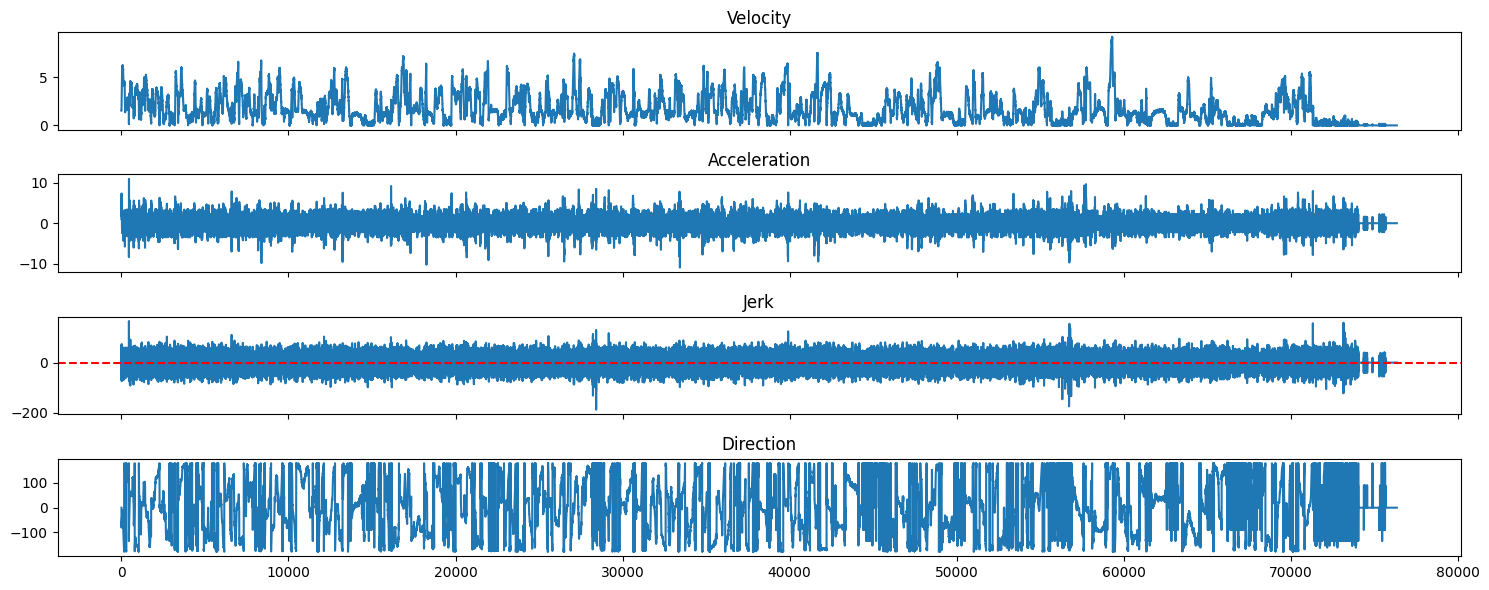

In [21]:
x_ax = range(len(v_list))


fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, figsize = [15,6])
#fig.suptitle("Tracking data metrics visualisation")
ax1.plot(x_ax, v_list)
ax1.set_title("Velocity")
ax2.plot(x_ax, a_list)
ax2.set_title("Acceleration")
ax3.plot(x_ax, j_list)
ax3.set_title("Jerk")
ax3.axhline(0, color="red", linestyle = "--")
ax4.plot(x_ax, d_list)
ax4.set_title("Direction")
fig.tight_layout()


In [22]:
print(len(d_list),len(v_list), len(a_list), len(j_list))

76366 76366 76366 76366


In [23]:
# workflow
# 1_find jerk going from negative to positive
# 2_find jerk going together with direction change
# 3_check if there is a speed drop and deceleration (set cutoff)

In [24]:
# each frame = 0.04s --> to get a stable  measurement --> take the average of 4 frames
# 1) start velocity above speed treshold | end velocity above speed treshold
# 2) start jerk = - | middle jerk = + | end jerk = -
# 3) absolute value of direction change greater than target change
# acceleration & deceleration treshold?
# start loop at frame 0 
# increase with 1 frame at a time until COD detection --> if COD go to next 2s window (+50 frames)

frame_counter=0 
cod_counter=0    
window_size=50

while frame_counter<len(j_list)-50 :  # ensure enough data remains for a full 2s window

    # Indices for 3 segments of 10 frames (0.4s each)
    start_1, start_2 = frame_counter, frame_counter+10
    middle_1, middle_2 = frame_counter+20, frame_counter+30
    end_1, end_2 = frame_counter+40, frame_counter+50

    # Averaging over the 10-frame segments
    j_start = np.mean(j_list[start_1:start_2])
    v_start = np.mean(v_list[start_1:start_2]) 
    d_start = np.mean(d_list[start_1:start_2]) 

    j_middle = np.mean(j_list[middle_1:middle_2]) 
    v_middle = np.mean(v_list[middle_1:middle_2]) 
    d_middle = np.mean(d_list[middle_1:middle_2]) 

    j_end = np.mean(j_list[end_1:end_2]) 
    v_end = np.mean(v_list[end_1:end_2]) 
    d_end = np.mean(d_list[end_1:end_2]) 

    # Apply COD conditions
    if v_start>4 and v_end>3:  # velocity threshold at start and end
        if j_start<0 and j_middle>0 and j_end<0:  # jerk pattern
            if abs(d_start-d_end)>45:  # minimum directional change in degrees
                cod_counter+=1
                frame_counter+=window_size # move to next 2-second window
                continue

    frame_counter+=1
print(cod_counter)

44


Brenda et al 2022: Quantifying change of direction load using positional data from small-sided games in soccer

-done-

In [61]:
# calculate the speed in the x and y direction per frame
vx_list = [] # store speed in x direction per frame
vy_list = [] # store speed in y direction per frame
v_list_brenda = [] # store speed per frame

for i in range(len(x)): 
    if i>0:
        vx=(x[i]-x[i-1])/delta_t
        vy=(y[i]-y[i-1])/delta_t
        v = sqrt((vx**2)+(vy**2))
        
    else: 
        vx=0
        vy=0
        v=0
        
    vx_list.append(vx)
    vy_list.append(vy)
    v_list_brenda.append(v)
    
    #print(v)

# equal speed in frame 2 to frame 1 to avoid incorrect 0 speed   
vx_list[0]=vx_list[1] 
vy_list[0]=vy_list[1] 
v_list_brenda[0]=v_list_brenda[1] 

In [63]:
v_list_brenda

[1.5206906325745229,
 1.5206906325745229,
 1.5206906325745673,
 1.8200274723201366,
 2.136000936329385,
 2.3717082451262814,
 2.3584952830141526,
 2.462214450449023,
 2.8504385627478426,
 2.915475947422643,
 3.201562118716452,
 3.4003676271838494,
 3.2015621187164176,
 3.55316760088798,
 3.750000000000002,
 4.100304866714179,
 4.100304866714179,
 3.905124837953329,
 4.422951503238531,
 4.422951503238531,
 4.422951503238531,
 4.776243293635699,
 4.776243293635701,
 4.776243293635711,
 5.129571132170791,
 4.962358310319803,
 5.129571132170791,
 5.153882032022091,
 5.315072906367318,
 5.315072906367322,
 5.700877125495693,
 5.350233639758171,
 5.505678886386312,
 5.700877125495679,
 5.700877125495701,
 5.900211860602967,
 5.857687256929999,
 6.051859218455093,
 6.051859218455106,
 6.051859218455106,
 6.249999999999996,
 6.1032778078668635,
 6.051859218455085,
 6.103277807866856,
 6.309714732061982,
 5.9634302209382835,
 6.174544517614232,
 6.046693311223913,
 6.149186938124415,
 6.0415229

In [64]:
ha_list = [] # list to store heading angles

for i in range(len(vx_list)):
    if vy_list[i]==0 or vx_list[i]==0: #division by 0 would give an error --> just assign 0 as heading angle
        ha=0
    else: # --> calculate heading angle using formula in brenda et al.2022
        vector=vy_list[i]/vx_list[i]
        ha=degrees(atan(vector))
    
    ha_list.append(ha)

define windows
--> window size = 1s = 25Hz

In [159]:
k=0.0035
v_25=[]
heading_change_25=[]
veloctity_curvature_cutoff=[]
window_size=25 
frame_counter=0 
cod_counter = 0

while frame_counter<len(ha_list)-window_size:
    # calculate the average speed per window
    v=np.mean(v_list_brenda[frame_counter:frame_counter+window_size])
    v_25.append(v)
    # calculate delta value of the heading change per window
    delta_ha=(ha_list[frame_counter+window_size]-ha_list[frame_counter])/(window_size*delta_t) # time delta = 1 second
    heading_change_25.append(delta_ha)
    # compute cutoff only if delta_ha is large enough
    if abs(delta_ha) >= 1:
        cutoff=1/(k*abs(delta_ha))
        
        if v>cutoff:
            cod_counter += 1
    # extra option to calculate COD load using formula: load = v - cutoff    
    else:
        cutoff = np.nan  # mark as invalid or too small to matter

    veloctity_curvature_cutoff.append(cutoff)
    
    frame_counter+=25

cod_counter

53

Text(0.5, 0, 'Velocity (m/s2)')

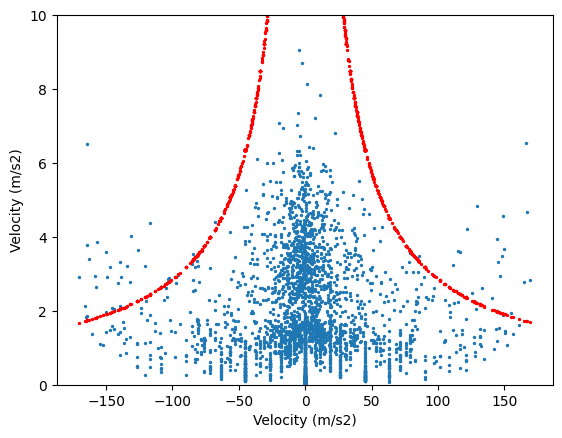

In [160]:
fig, ax = plt.subplots()
ax.scatter(heading_change_25, v_25, s=2)
ax.scatter(heading_change_25, veloctity_curvature_cutoff, s=2, color="red")
ax.set_ylim(0,10)
ax.set_ylabel("Velocity (m/s2)")
ax.set_xlabel("Velocity (m/s2)")


Reilly et al. 2021:  Automated Classification of Changes of Direction in Soccer Using Inertial Measurement Units
- average time bbetween start & end COD = 3.1s
- COD angle as one of ‘0–45 DEG’, ‘45–90 DEG’, ‘90–135 DEG’, ‘135–180DEG’
- extra machine learning model based on video analysis

In [98]:
print(x)
print(y)

[-0.57, -0.56, -0.55, -0.53, -0.5, -0.47, -0.42, -0.38, -0.31, -0.25, -0.17, -0.09, -0.01, 0.08, 0.17, 0.27, 0.37, 0.47, 0.59, 0.71, 0.83, 0.97, 1.11, 1.25, 1.4, 1.55, 1.7, 1.86, 2.02, 2.18, 2.36, 2.53, 2.7, 2.88, 3.06, 3.25, 3.43, 3.62, 3.81, 4.0, 4.2, 4.4, 4.59, 4.79, 5.0, 5.2, 5.41, 5.62, 5.84, 6.06, 6.28, 6.5, 6.73, 6.96, 7.19, 7.42, 7.66, 7.9, 8.13, 8.37, 8.61, 8.84, 9.08, 9.32, 9.55, 9.78, 10.01, 10.24, 10.46, 10.68, 10.9, 11.11, 11.32, 11.52, 11.72, 11.91, 12.1, 12.28, 12.46, 12.63, 12.79, 12.95, 13.1, 13.25, 13.39, 13.53, 13.66, 13.79, 13.91, 14.03, 14.14, 14.24, 14.34, 14.44, 14.53, 14.61, 14.69, 14.75, 14.82, 14.88, 14.93, 14.98, 15.02, 15.05, 15.08, 15.09, 15.11, 15.11, 15.11, 15.1, 15.09, 15.07, 15.04, 15.0, 14.97, 14.92, 14.86, 14.8, 14.74, 14.67, 14.59, 14.51, 14.42, 14.32, 14.22, 14.12, 14.01, 13.89, 13.77, 13.65, 13.52, 13.39, 13.26, 13.12, 12.98, 12.83, 12.68, 12.53, 12.38, 12.22, 12.06, 11.9, 11.74, 11.58, 11.41, 11.24, 11.07, 10.9, 10.72, 10.55, 10.37, 10.2, 10.02, 9

In [163]:
print(len(x))
print(len(v_list))

76366
76366


In [ ]:
frame_counter = 0
cod_counter=0

while frame_counter<len(x)-60:    
        
    x1=sum(x[frame_counter:frame_counter+10])/10
    y1=sum(y[frame_counter:frame_counter+10])/10
    v1=sum(v_list[frame_counter:frame_counter+10])/10
        
    x2=sum(x[frame_counter+25:frame_counter+35])/10
    y2=sum(y[frame_counter+25:frame_counter+35])/10
    v2=sum(v_list[frame_counter+25:frame_counter+35])/10
               
    x3=sum(x[frame_counter+50:frame_counter+60])/10
    y3=sum(y[frame_counter+50:frame_counter+60])/10
    v3=sum(v_list[frame_counter+50:frame_counter+60])/10

    a=sqrt(((x2-x3)**2)+((y2-y3)**2)) # distance between 2nd and 3th points cluster
    b=sqrt(((x1-x3)**2)+((y1-y3)**2)) # distance between 1st and 3th points cluster
    c=sqrt(((x1-x2)**2)+((y1-y2)**2)) # distance between 1st and 2nd points cluster
        
    if a != 0 and c != 0:
        #cod=180-(degrees(acos(((a**2)+(c**2)-(b**2))/(2*a*c))))
        cos_angle=max(-1, min(1,((a**2+c**2-b**2)/(2*a*c))))
        cod=180-(degrees(acos(cos_angle)))
            
        # filter on COD angle | start speed | end speed
        if cod>45 and v1>3 and v3>3:# and v2<1:
            cod_counter+=1

            frame_counter+=60 # COD is detected, go to the next window

        else:
            frame_counter+=1 # no COD detected, move to next frame
    else:
        frame_counter+=1 # no COD detected, move to next frame

print(cod_counter)
# filteren op snelheid

44
